In this notebook, we will explore detection whether text is generated by Large Language using LSTM (Long Short-Term Memory) models.

## Importing Libraries

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA


2024-01-14 16:10:34.152684: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 16:10:34.400333: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 16:10:34.400439: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-14 16:10:34.445446: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-14 16:10:34.538640: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 16:10:34.540481: I tensorflow/core/platform/cpu_feature_guard.cc:1

## Configuration

In [2]:
class CFG:
    sequence_length = 1024
    vocab_size = 10000
    is_training = False

## Loading the Data

 Reading the training dataset from a CSV file

In [3]:
train_df = pd.read_csv("daigt-v2-train-dataset/train_v2_drcat_02.csv")
train_df.head()

,text,label,prompt_name,source,RDizzl3_seven
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False


## Exploring the Data

Plot a bar chart to visualize the value counts of the "label" column in the train_df dataframe. It helps us see the distribution of generated and real texts in the dataset. 

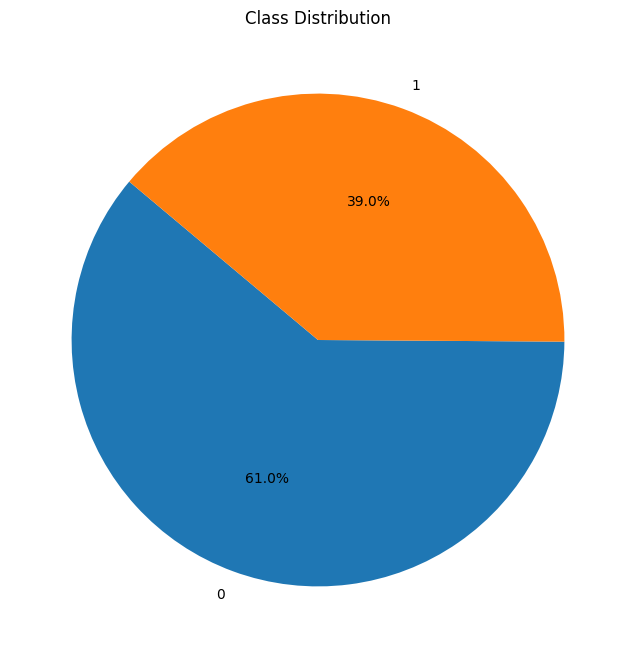

In [4]:
label_counts = train_df['label'].value_counts()

# Create a pie chart with percentage display
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Class Distribution')
plt.show()

<Axes: title={'center': 'Data Collection Sources'}, xlabel='prompt_name'>

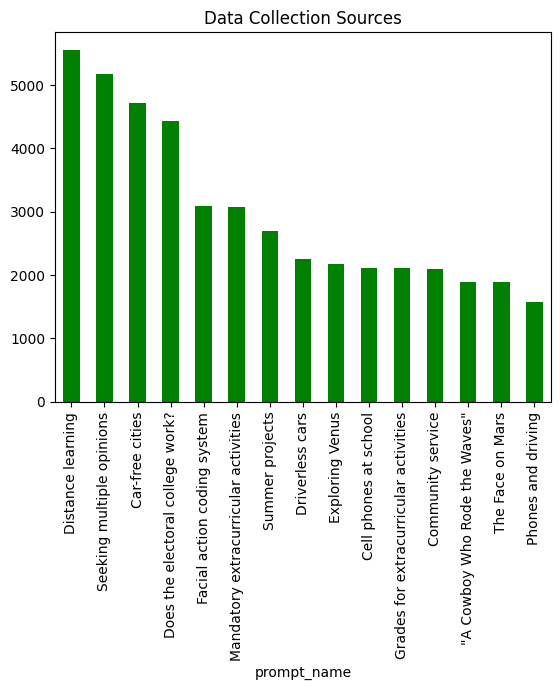

In [7]:
train_df.prompt_name.value_counts().plot(kind="bar", color = ["green"], title="Data Collection Sources")

<Axes: title={'center': 'Data distribution by different GPT models'}, xlabel='source'>

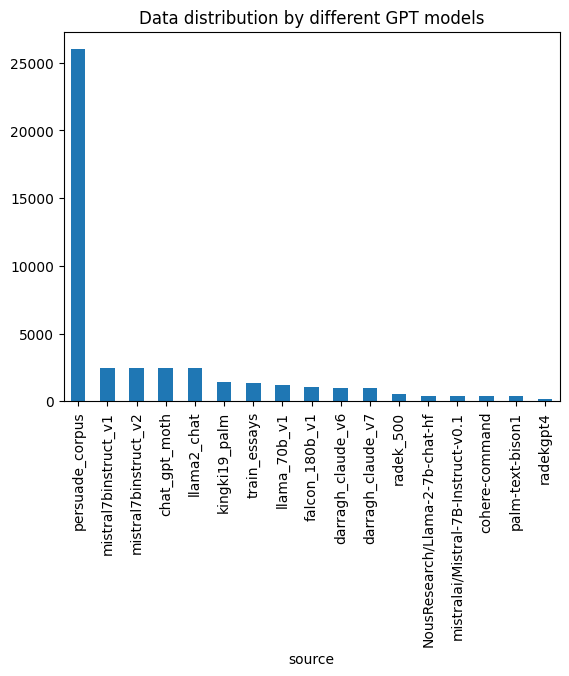

In [8]:
train_df.source.value_counts().plot(kind="bar", title = "Data distribution by different GPT models")

Calculate the number of words in the **text** column using the lambda function which will be helpful for analyzing the length of titles and texts in this dataset. 

In [10]:
train_df["text_length"] = train_df["text"].apply(lambda text: len(text.split(" ")))

Generate descriptive statistics for the "text_length" columns. It provides useful information such as count, mean, standard deviation, minimum value, and quartiles. This summary gives us a quick overview of the distribution and basic statistics of the lengths of texts in the dataset.

In [11]:
train_df[["text_length"]].describe()

,text_length
count,44868.000000
mean,386.142440
std,225.375414
min,4.000000
25%,273.000000
50%,350.000000
75%,451.000000
max,14818.000000


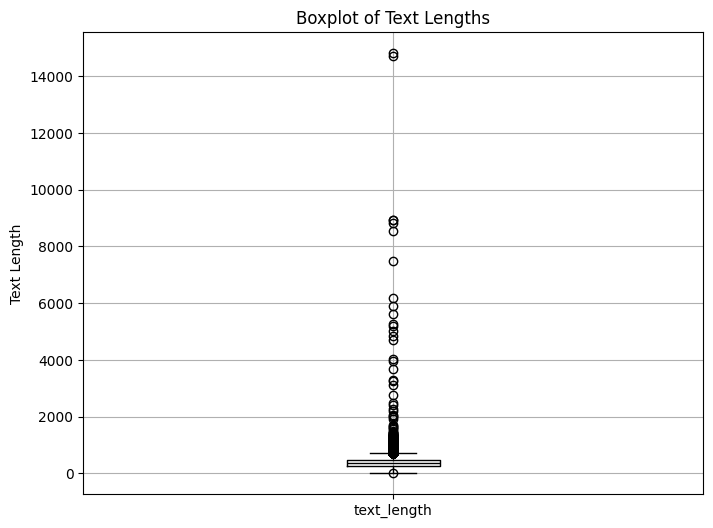

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
train_df.boxplot(column='text_length', grid=True, color='black')
plt.title('Boxplot of Text Lengths')
plt.ylabel('Text Length')
plt.show()

 Visualize the distribution of values of text length.

## Creating tensorflow dataset

In [6]:
train_data, valid_data = train_test_split(train_df, test_size=0.2, stratify=train_df["label"], random_state=42)
train_data.shape, valid_data.shape

((35894, 5), (8974, 5))

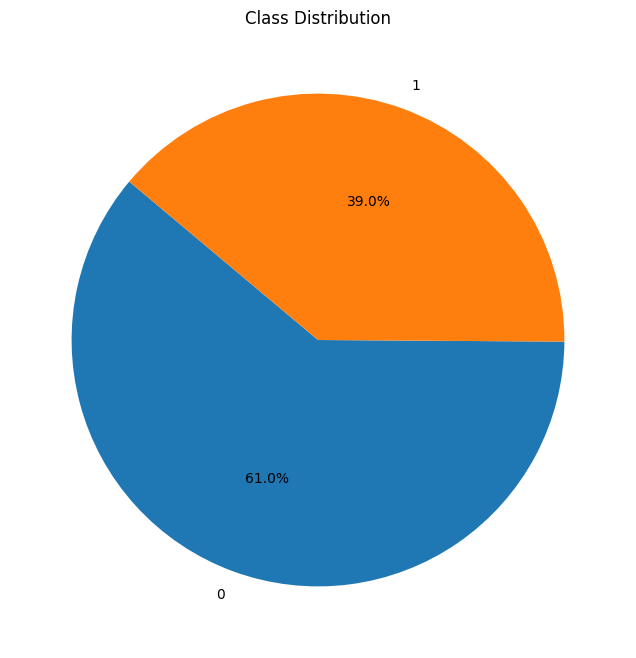

In [7]:
label_counts = train_data['label'].value_counts()

# Create a pie chart with percentage display
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Class Distribution')
plt.show()

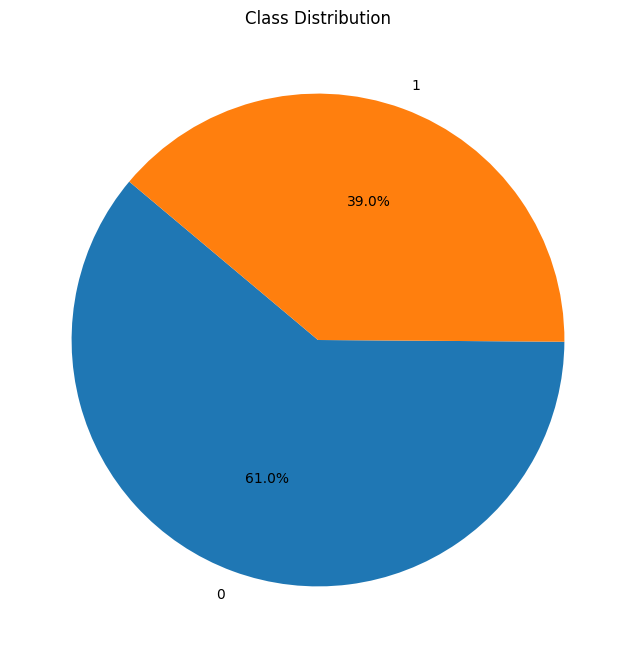

In [8]:
label_counts = valid_data['label'].value_counts()

# Create a pie chart with percentage display
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Class Distribution')
plt.show()

In [13]:
def create_dataset(dataframe, shuffle=True):
    # Create a TensorFlow dataset from the text and label columns of the dataframe
    dataset = tf.data.Dataset.from_tensor_slices((dataframe["text"], dataframe["label"]))
    if shuffle:
        # Shuffle the dataset if the shuffle parameter is True
        dataset = dataset.shuffle(1024, reshuffle_each_iteration=True)
    # Batch the dataset into smaller batches of size 256
    dataset = dataset.batch(256).cache().prefetch(tf.data.AUTOTUNE)
    # Prefetch the next batch of data to further optimize training
    return dataset

In [14]:
train_ds = create_dataset(train_data)
valid_ds = create_dataset(valid_data, shuffle=False)

## Training the LSTM Model

In [15]:
# Create a TextVectorization layer with specified parameters
vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=CFG.vocab_size, 
    output_sequence_length=CFG.sequence_length, 
    pad_to_max_tokens=True
)
# Adapt the TextVectorization layer to the training data
vectorizer.adapt(train_df["text"], batch_size=1024)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 1024)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 1024, 64)          640000    
                                                                 
 bidirectional (Bidirection  (None, 1024, 128)         66048     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                        

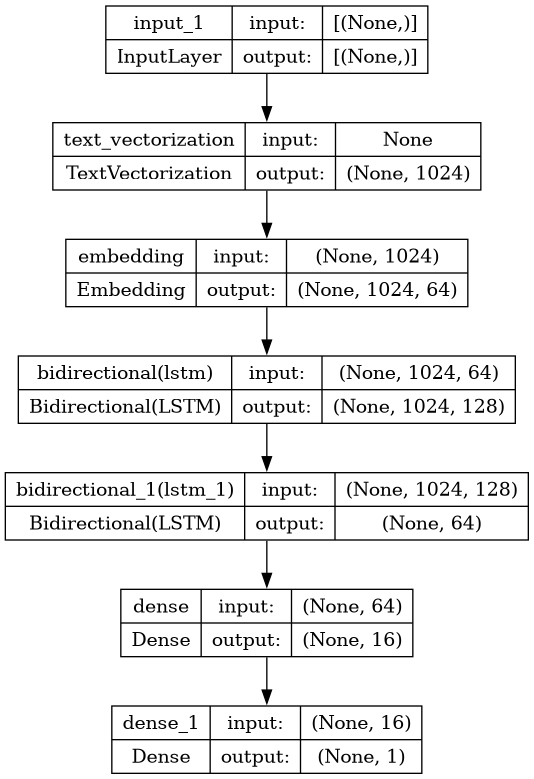

In [16]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    vectorizer,
    tf.keras.layers.Embedding(
        input_dim=CFG.vocab_size, 
        output_dim=64,
        input_length=CFG.sequence_length, 
        mask_zero=True
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)), 
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)), 
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), 
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
    metrics=[
        "accuracy", 
        tf.keras.metrics.AUC(name="auc")
    ]
)
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

In [15]:
file_path = "trained_model"

# Check if it is a training phase
    # Train the model
history = model.fit(
    train_ds, 
    epochs=20, 
    validation_data=valid_ds,
    callbacks=[
        # Save the best model based on validation AUC score
        tf.keras.callbacks.ModelCheckpoint(
            file_path,
            save_best_only=True,
            monitor='val_auc',
            mode='max'
        )
    ]
)


Epoch 1/20
141/141 [==============================] - 123s 738ms/step - loss: 0.2888 - accuracy: 0.8781 - auc: 0.9475 - val_loss: 0.1245 - val_accuracy: 0.9710 - val_auc: 0.9905
Epoch 2/20
141/141 [==============================] - 74s 529ms/step - loss: 0.1386 - accuracy: 0.9523 - auc: 0.9869 - val_loss: 0.0507 - val_accuracy: 0.9863 - val_auc: 0.9975
Epoch 3/20
141/141 [==============================] - 75s 531ms/step - loss: 0.0371 - accuracy: 0.9901 - auc: 0.9980 - val_loss: 0.0393 - val_accuracy: 0.9880 - val_auc: 0.9987
Epoch 4/20
141/141 [==============================] - 35s 247ms/step - loss: 0.0382 - accuracy: 0.9896 - auc: 0.9979 - val_loss: 0.0507 - val_accuracy: 0.9837 - val_auc: 0.9967
Epoch 5/20
141/141 [==============================] - 35s 248ms/step - loss: 0.0233 - accuracy: 0.9938 - auc: 0.9988 - val_loss: 0.0359 - val_accuracy: 0.9889 - val_auc: 0.9982
Epoch 6/20
141/141 [==============================] - 35s 248ms/step - loss: 0.0151 - accuracy: 0.9965 - auc: 0.99

## Ploting learning curve
Plot learning curve if the notebook is in training phase.

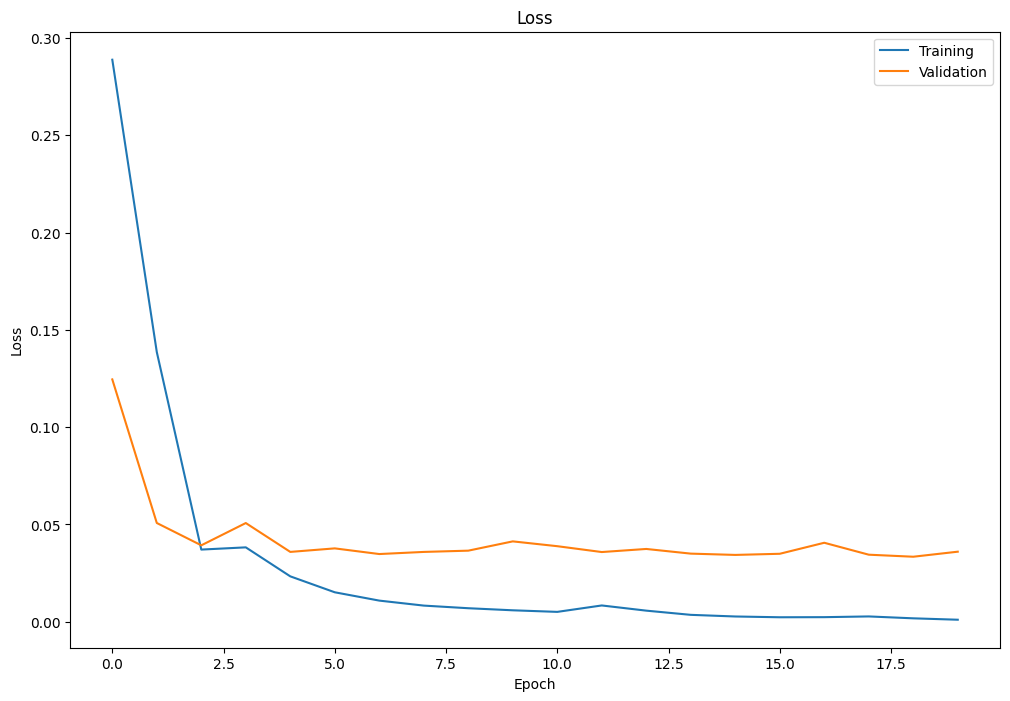

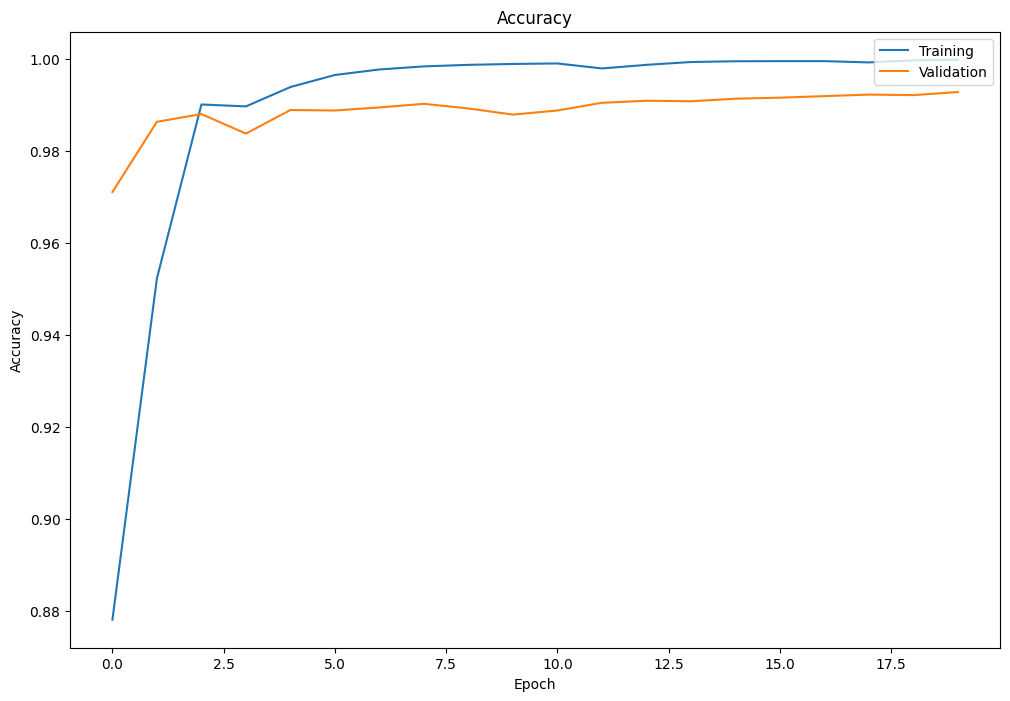

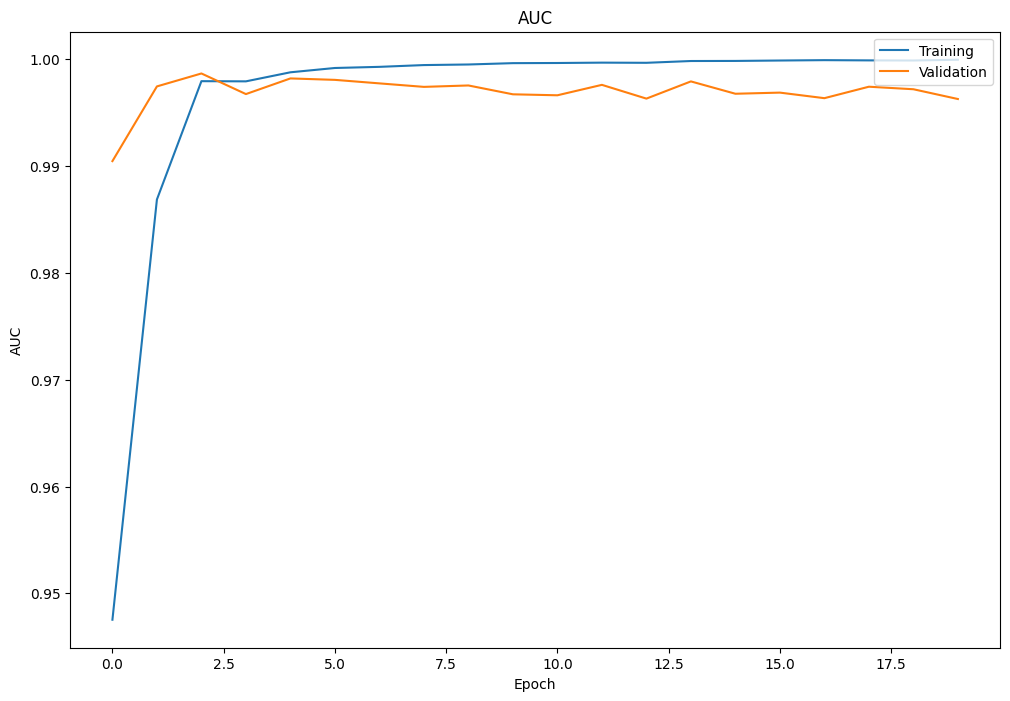

In [17]:
def plot_learning_curve(history):
  plt.figure(figsize=(12, 8))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Validation'], loc='upper right')

  plt.figure(figsize=(12, 8))
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Validation'], loc='upper right')

  plt.figure(figsize=(12, 8))
  plt.plot(history.history['auc'])
  plt.plot(history.history['val_auc'])
  plt.title('AUC')
  plt.ylabel('AUC')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Validation'], loc='upper right')
  plt.show()

plot_learning_curve(history)

## PCA analysis

In [ ]:
layer = model.get_layer('embedding')
intermediate_model = tf.keras.Model(inputs=model.input, outputs=layer.output)
features = intermediate_model.predict(X)

pca = PCA(n_components=3)
reduced_features = pca.fit_transform(features)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


ax.scatter(reduced_features[:, 0], reduced_features[:, 1], reduced_features[:, 2], c=y)

ax.set_title("3D PCA")
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
plt.show()

![Alt text](3d-PCA.png)


## Model Evaluation

In [18]:
val_loss, val_accuracy, val_auc = model.evaluate(valid_ds)
print(f"Validation Loss: {val_loss: .4f}")
print(f"Validation Accuracy: {val_accuracy: .4f}")
print(f"Validation AUC: {val_auc: .4f}")

36/36 [==============================] - 14s 104ms/step - loss: 0.0219 - accuracy: 0.9938 - auc: 0.9988
Validation Loss:  0.0219
Validation Accuracy:  0.9938
Validation AUC:  0.9988


In [36]:
valid_data["generated"] = model.predict(valid_data["text"])
valid_data

281/281 [==============================] - 13s 47ms/step


,text,label,prompt_name,source,RDizzl3_seven,text_length,generated,pred_class
25721,Advice about receiving advice\n\nDoing somethi...,0,Seeking multiple opinions,persuade_corpus,False,414,0.000017,0
2844,"Cars, some people think they are the most impo...",0,Car-free cities,persuade_corpus,True,434,0.000034,0
5726,Seagoing\n\nDo you want an adventure? Maybe yo...,0,"""A Cowboy Who Rode the Waves""",persuade_corpus,True,390,0.000084,0
19708,I think they should go by popular vote ! beacu...,0,Does the electoral college work?,persuade_corpus,True,3097,0.000021,0
11234,Do you believe that there is a computer that c...,0,Facial action coding system,persuade_corpus,True,179,0.000086,0
...,...,...,...,...,...,...,...,...
34531,"[Your Name]\n[Your Address]\n[City, State, ZIP...",1,Does the electoral college work?,radek_500,True,603,1.000000,1
31905,Taking the traditional four years to complete ...,1,Distance learning,chat_gpt_moth,False,256,1.000000,1
18193,"The future is near, and it's bringing what Ame...",0,Driverless cars,persuade_corpus,True,358,0.000034,0
30048,"Hey, so I'm gonna write this essay about why f...",1,Seeking multiple opinions,llama2_chat,False,359,1.000000,1


In [ ]:
def apply_threshold(x):
    if x>0.5:
        return 1
    else: return 0

valid_data["pred_class"] = valid_data["generated"].apply(apply_threshold)
valid_data

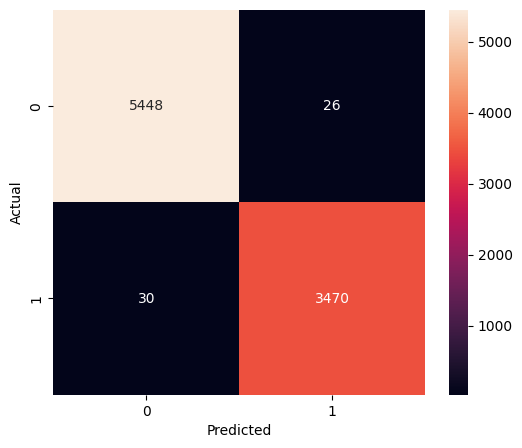

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
confusion_mtx = confusion_matrix(valid_data["label"], valid_data["pred_class"])
# plot the confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(confusion_mtx, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Replace these with your actual data
true_labels = valid_data["label"]
predicted_labels = valid_data["pred_class"]

# Calculate overall accuracy
overall_accuracy = accuracy_score(true_labels, predicted_labels)

# Calculate per-class precision, recall, and F1 score
per_class_precision = precision_score(true_labels, predicted_labels, average=None)
per_class_recall = recall_score(true_labels, predicted_labels, average=None)
per_class_f1 = f1_score(true_labels, predicted_labels, average=None)

# Calculate per-class accuracies
conf_matrix = confusion_matrix(true_labels, predicted_labels)
per_class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

print("Overall Accuracy:", overall_accuracy)
print("Per-class Precision:", per_class_precision)
print("Per-class Recall:", per_class_recall)
print("Per-class F1 Score:", per_class_f1)
print("Per-class Accuracy:", per_class_accuracy)

```
Overall Accuracy: 0.9937597503900156
Per-class Precision: [0.99452355 0.99256293]
Per-class Recall: [0.99525027 0.99142857]
Per-class F1 Score: [0.99488678 0.99199543]
Per-class Accuracy: [0.99525027 0.99142857]
```